   surg_card_id PrimarySurgeonDurableKey PatientInRoomInstant  NumberOpen  \
0             1                 SurgeonC           2023-01-01           3   
1             2                 SurgeonA           2023-01-02           0   
2             3                 SurgeonC           2023-01-03           1   
3             4                 SurgeonC           2023-01-04           0   
4             5                 SurgeonC           2023-01-05           2   

   NumberPrn  NumberUsed  time_from_start  TargetOpen  TargetProvisioned  \
0          3           2                0           2                  2   
1          1           4                1           2                  2   
2          4           3                2           2                  2   
3          1           4                3           2                  2   
4          4           1                4           2                  2   

   RelativeLikelihood  
0                   2  
1                   0  
2       

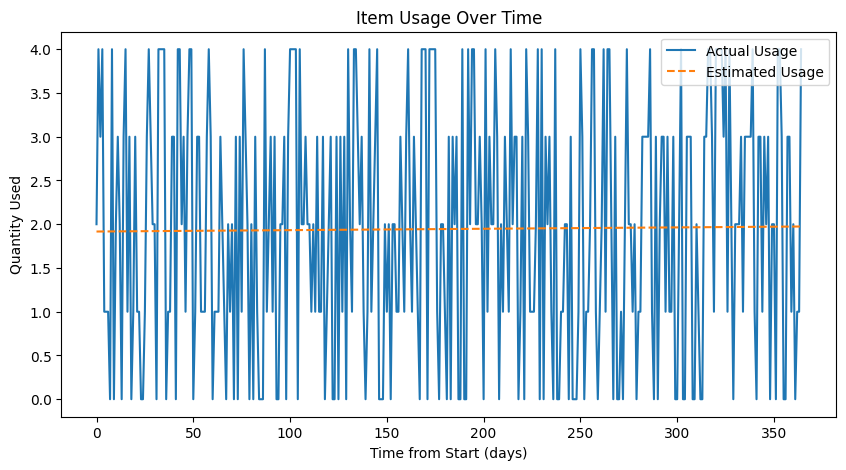

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = {
    'surg_card_id': np.arange(1, 366),
    'PrimarySurgeonDurableKey': np.random.choice(['SurgeonA', 'SurgeonB', 'SurgeonC'], size=365),
    'PatientInRoomInstant': pd.date_range(start='2023-01-01', periods=365, freq='D'),
    'NumberOpen': np.random.choice([0, 1, 2, 3, 4], size=365),
    'NumberPrn': np.random.choice([0, 1, 2, 3, 4], size=365),
    'NumberUsed': np.random.choice([0, 1, 2, 3, 4], size=365)
}


usage_data = pd.DataFrame(data)
usage_data['time_from_start'] = (usage_data['PatientInRoomInstant'] - usage_data['PatientInRoomInstant'].min()).dt.days

#least squares regression model 
def fit_least_squares(data):
    X = data['time_from_start'].values
    y = data['NumberUsed'].values
    A = np.vstack([X, np.ones(len(X))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c


def estimate_usage(m, c, period=365):
    future_times = np.arange(period)
    estimated_usage = m * future_times + c
    return estimated_usage


def calculate_target_quantities(data, estimated_usage, percentile=90):
    target_open = max(0, estimated_usage[-1])
    actual_usage = data['NumberUsed']
    target_provisioned = np.percentile(actual_usage, percentile) - target_open
    target_provisioned = max(0, target_provisioned)
    return round(target_open), round(target_provisioned)


def calculate_relative_likelihood(data, target_open, target_provisioned):
    data['TargetOpen'] = target_open
    data['TargetProvisioned'] = target_provisioned
    data['RelativeLikelihood'] = abs(data['NumberUsed'] - (data['TargetOpen'] + data['TargetProvisioned']))
    return data

m, c = fit_least_squares(usage_data)
estimated_usage = estimate_usage(m, c)


target_open, target_provisioned = calculate_target_quantities(usage_data, estimated_usage)


final_data = calculate_relative_likelihood(usage_data, target_open, target_provisioned)


print(final_data.head())


plt.figure(figsize=(10, 5))
plt.plot(usage_data['time_from_start'], usage_data['NumberUsed'], label='Actual Usage')
plt.plot(np.arange(365), estimated_usage, label='Estimated Usage', linestyle='--')
plt.xlabel('Time from Start (days)')
plt.ylabel('Quantity Used')
plt.title('Item Usage Over Time')
plt.legend()
plt.show()

In [13]:
usage_data

,SurgicalCaseKey,PrimarySurgeonDurableKey,PatientInRoomInstant,NumberOpen,NumberPrn,NumberUsed,time_from_start
0,1,SurgeonB,2023-01-01,2,1,2,0
1,2,SurgeonB,2023-01-02,2,3,0,1
2,3,SurgeonA,2023-01-03,1,4,2,2
3,4,SurgeonA,2023-01-04,2,2,2,3
4,5,SurgeonB,2023-01-05,3,4,1,4
...,...,...,...,...,...,...,...
360,361,SurgeonA,2023-12-27,2,2,1,360
361,362,SurgeonB,2023-12-28,4,2,3,361
362,363,SurgeonB,2023-12-29,0,3,3,362
363,364,SurgeonA,2023-12-30,0,0,4,363
